# 1. Contexto

**Proyecto:** Análisis de Sentimientos - Reseñas de Hoteles </br> 
**Dataset:** `Big_AHR.csv` </br>
**Origen**: https://www.kaggle.com/datasets/chizhikchi/andalusian-hotels-reviews-unbalanced?select=Big_AHR.csv </br>
**Objetivo:** Realizar una auditoría completa del dataset, limpiar ruidos y preparar el texto para el modelado.

# 2. Configuracion del entorno

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuración de visualización
%matplotlib inline
sns.set_theme(style="whitegrid")
pd.set_option('display.max_colwidth', 150) # Para leer bien las reseñas

## Carga de datos
Cargamos el archivo original y realizamos una primera inspección visual de las columnas y el encoding.

In [2]:
path = '../data/raw/Big_AHR.csv'
df = pd.read_csv(path, index_col=0)

print(f"Dimensiones del dataset: {df.shape}")
df.sample(5)

Dimensiones del dataset: (18172, 6)


,title,rating,review_text,location,hotel,label
2396,Encantados,5,"Nos gustó muchísimo el estudio deluxe, la cama extra grande es una pasada más la bañera y la ducha estuvimos encantados!! está mucho mejor que en ...",Seville_Province_of_Seville_Andalucia,Hom_Sevilla,1
10629,Fab!!,5,Stayed here for 2 wonderful nights. I’m not sure why there isn’t many reviews here (I was skeptical when I first booked it) but this little place ...,Cordoba_Province_of_Cordoba_Andalucia,Homesuitehome,1
3892,De paso por negocios en Malaga.,4,"Hotel muy enfocado a empresa. Tienen lo que un viajero de negocios necesita y saben hacerlo bien. Hotel con parking gratuito, fácil acceso, limpio...",Malaga_Costa_del_Sol_Province_of_Malaga_Andalucia,Campanile_Malaga,1
1061,Habitaciones muy bonitas.,3,"Habitaciones frias y calientes dependiendo de la estación del año, se soluciona con un calentador y con un aparato de aire a condicionado. pero en...",Seville_Province_of_Seville_Andalucia,Hotel_Rural_Hacienda_Molino_la_Boticaria,3
11755,Muy recomendable. Funcional y agradable. Bien situado,5,"Los empleados son muy amables, no se puede pedir grandes lujos, pero es normal por el precio que tiene. Yo estuve en una habitación doble con mi p...",Cordoba_Province_of_Cordoba_Andalucia,Puerta_de_la_Luna,1


# 4. Auditoria de calidad y limpieza inicial
En esta sección identificamos valores nulos, registros duplicados y tipos de datos incorrectos.

## Informacion general

In [3]:
# 4.1. Información General
print("--- Información del Dataset ---")
df.info()

--- Información del Dataset ---
<class 'pandas.core.frame.DataFrame'>
Index: 18172 entries, 0 to 18171
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        18172 non-null  object
 1   rating       18172 non-null  int64 
 2   review_text  18172 non-null  object
 3   location     16356 non-null  object
 4   hotel        16356 non-null  object
 5   label        18172 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 993.8+ KB


## Deteccion de nulos

In [4]:
# 4.2. Detección de Nulos
print("\n--- Valores Nulos por Columna ---")
print(df.isnull().sum())


--- Valores Nulos por Columna ---
title             0
rating            0
review_text       0
location       1816
hotel          1816
label             0
dtype: int64


## Deteccion de duplicados

In [5]:
# 4.3. Detección de Duplicados
# Es vital en NLP borrar reseñas idénticas
duplicates = df.duplicated(subset=['review_text']).sum()
print(f"\nReseñas duplicadas encontradas: {duplicates}")


Reseñas duplicadas encontradas: 4842


Reseñas duplicadas (4,842): Es el conteo de las "copias". Si una reseña aparece 3 veces, pandas cuenta 2 como duplicados.

### Visualizacion de filas duplicadas
Antes de eliminar, es importante inspeccionar qué contenido se está repitiendo para asegurar que no estamos perdiendo información valiosa.

In [6]:
# Filtramos el dataframe para ver solo las filas que tienen el texto de la reseña repetido
# keep=False nos permite ver TODAS las ocurrencias (la original y sus copias)
duplicados_view = df[df.duplicated(subset=['review_text'], keep=False)]

# Ordenamos por 'review_text' para que las filas idénticas queden juntas y sea fácil comparar
duplicados_view = duplicados_view.sort_values(by='review_text')

print(f"Total de filas involucradas en duplicidad: {len(duplicados_view)}")
duplicados_view.head(10) # Mostramos las primeras 10 para inspeccionar


Total de filas involucradas en duplicidad: 8063


,title,rating,review_text,location,hotel,label
7176,Apartamentos ideales,4,"En nuestra visita a Granada decidimos quedarnos en estos apartamentos, situados en el barrio del Albaicín, zona turística, de marcado carácter ...",Granada_Province_of_Granada_Andalucia,Smart_Suites_Albaicin,1
8200,Apartamentos ideales,4,"En nuestra visita a Granada decidimos quedarnos en estos apartamentos, situados en el barrio del Albaicín, zona turística, de marcado carácter ...",Granada_Province_of_Granada_Andalucia,Smart_Suites_Albaicin,1
8240,MAGNIFICO,5,"Encontré los apartamentos estupendos. Muy limpios, sin faltar nada y la gente de recepción muy agradables. El sitio insuperable, muy céntric...",Granada_Province_of_Granada_Andalucia,Habitat_Suites_Gran_Via,1
7271,MAGNIFICO,5,"Encontré los apartamentos estupendos. Muy limpios, sin faltar nada y la gente de recepción muy agradables. El sitio insuperable, muy céntric...",Granada_Province_of_Granada_Andalucia,Habitat_Suites_Gran_Via,1
4758,A 1000 m du centre historique,2,"1er point positif ,accueil chaleureux de Javier . 2ème point positif c’est pas cher ( 72€ pour appt 2 chambres 4 couchages). Dans un immeuble a...",Malaga_Costa_del_Sol_Province_of_Malaga_Andaluci,Apartamentos_Fernando_el_Catolico_33,0
4768,A 1000 m du centre historique,2,"1er point positif ,accueil chaleureux de Javier . 2ème point positif c’est pas cher ( 72€ pour appt 2 chambres 4 couchages). Dans un immeuble a...",Malaga_Costa_del_Sol_Province_of_Malaga_Andaluci,Apartamentos_Fernando_el_Catolico_33,0
4763,A 1000 m du centre historique,2,"1er point positif ,accueil chaleureux de Javier . 2ème point positif c’est pas cher ( 72€ pour appt 2 chambres 4 couchages). Dans un immeuble a...",Malaga_Costa_del_Sol_Province_of_Malaga_Andaluci,Apartamentos_Fernando_el_Catolico_33,0
11941,Correcto,3,"Dormí 2 noches, la habitación limpia y amplia, no use los servicios de restaurante pero lo que es la habitación... Correcta, está en el centro au...",Cordoba_Province_of_Cordoba_Andalucia,Hotel_Gonzalez,3
12227,Correcto,3,"Dormí 2 noches, la habitación limpia y amplia, no use los servicios de restaurante pero lo que es la habitación... Correcta, está en el centro au...",Cordoba_Province_of_Cordoba_Andalucia,Hotel_Gonzalez,3
6666,Muy acogedor.,4,"Hotel situado en el barrio de Albaicin, muy tranquilo y acogedor. El desayuno muy bueno y el personal simpáticos y atentos. Tiene un salón de est...",Granada_Province_of_Granada_Andalucia,Santa_Isabel_la_Real,1


Filas involucradas (8,063): Es el total de filas que forman parte de esos grupos de repetición (incluyendo la "original" y sus "copias").

#### Análisis profundo de duplicados
Para entender por qué hay tanta duplicidad (casi el 44% del dataset original según los números), agrupamos por texto y contamos las ocurrencias.

In [7]:
# Agrupamos por el texto de la reseña y contamos cuántas veces aparece cada una
top_duplicados = df.groupby('review_text').size().reset_index(name='cantidad')

# Ordenamos para ver las que más se repiten
top_duplicados = top_duplicados[top_duplicados['cantidad'] > 1].sort_values(by='cantidad', ascending=False)

print("Top 10 reseñas más repetidas:")
top_duplicados.head(10)

Top 10 reseñas más repetidas:


,review_text,cantidad
1536,"El Hotel Sierra de Huesa tiene una ubicación excelente, muy cerca de la Cueva del Agua y el Santuario de Tìscar, una visita muy interesante. Estab...",16
8403,Magnífica acogida y atención. Trato inmejorable. Muy atentos durante la estancia. Totalmente recomendable! Tienen una piscina en el tejado que en ...,16
3932,"Estuve alojado durante 3 noches, las habitaciones me parecieron bastante modernas, y la cama super cómoda, perfecta para descansar despues del via...",16
4497,"Está muy bien ubicado, en el mismo centro de Quesada, al lado del Bar Capri, el mejor sitio para comer/cenar y enfrente de la oficina de turismo, ...",16
1494,"Eine wunderschöne Herberge, nicht verstehen, wie man sagen kann, dass und so falsch, ich habe das gleiche Zimmer genommen und nicht wie in dem Kom...",12
9554,"No se puede criticar la ubicación dada el hostal está en el centro de la ciudad vieja. La habitación era pequeña y anticuada, pero limpia. El baño...",12
3035,"Era el único sitio de Jaén con habitación disponible en un fin de semana muy concurrido. Las habitaciones son sencillas y antiguas, pero está situ...",12
8008,"Llegamos a las 13:40 horas cargados después de 1 hora para aparcar ya que alli es imposible, nos echa a la calle porque hay que esperar hasta las ...",12
10491,"Pequeño y sencillo , buena gente , pleno centro , pero bien aislado contra el ruido . La única pega , la tubería de la calefacción parecía un inst...",12
11493,Stayed here for 2 wonderful nights. I’m not sure why there isn’t many reviews here (I was skeptical when I first booked it) but this little place ...,8


Esos datos confirman una sospecha común en datasets de hoteles: muchas reseñas se repiten porque son "basura" de sistema o frases extremadamente genéricas. Tener 4,842 duplicados en un dataset de 18,000 registros es un 26% de ruido. Si no se eliminan el modelo de Inteligencia Artificial va a "aprender de memoria" esas frases y perderá capacidad de generalizar.

#### Visualizacion completa de duplicados

In [8]:
# 1. Creamos un DataFrame que contiene todas las filas cuyo texto está repetido
# keep=False es la clave: le dice a pandas que marque TODAS las ocurrencias como True
df_ver_duplicados = df[df.duplicated(subset=['review_text'], keep=False)]

# 2. Lo ordenamos por el texto de la reseña. 
# Esto pondrá las filas idénticas juntas para que las veas cara a cara.
df_ver_duplicados = df_ver_duplicados.sort_values(by='review_text')

# 3. Mostramos el resultado
print(f"Se han encontrado {df_ver_duplicados.shape[0]} filas que forman parte de duplicados.")
df_ver_duplicados

Se han encontrado 8063 filas que forman parte de duplicados.


,title,rating,review_text,location,hotel,label
7176,Apartamentos ideales,4,"En nuestra visita a Granada decidimos quedarnos en estos apartamentos, situados en el barrio del Albaicín, zona turística, de marcado carácter ...",Granada_Province_of_Granada_Andalucia,Smart_Suites_Albaicin,1
8200,Apartamentos ideales,4,"En nuestra visita a Granada decidimos quedarnos en estos apartamentos, situados en el barrio del Albaicín, zona turística, de marcado carácter ...",Granada_Province_of_Granada_Andalucia,Smart_Suites_Albaicin,1
8240,MAGNIFICO,5,"Encontré los apartamentos estupendos. Muy limpios, sin faltar nada y la gente de recepción muy agradables. El sitio insuperable, muy céntric...",Granada_Province_of_Granada_Andalucia,Habitat_Suites_Gran_Via,1
7271,MAGNIFICO,5,"Encontré los apartamentos estupendos. Muy limpios, sin faltar nada y la gente de recepción muy agradables. El sitio insuperable, muy céntric...",Granada_Province_of_Granada_Andalucia,Habitat_Suites_Gran_Via,1
4758,A 1000 m du centre historique,2,"1er point positif ,accueil chaleureux de Javier . 2ème point positif c’est pas cher ( 72€ pour appt 2 chambres 4 couchages). Dans un immeuble a...",Malaga_Costa_del_Sol_Province_of_Malaga_Andaluci,Apartamentos_Fernando_el_Catolico_33,0
...,...,...,...,...,...,...
9405,Excelente,5,"⭐️⭐️⭐️⭐️⭐️Estuve tres noches para visitar Granada y la verdad es que me pareció muy limpio, muy buena la atención de los dueños y excelente la ubi...",Granada_Province_of_Granada_Andalucia,Broz_Hostel,1
7251,Excelente,5,"⭐️⭐️⭐️⭐️⭐️Estuve tres noches para visitar Granada y la verdad es que me pareció muy limpio, muy buena la atención de los dueños y excelente la ubi...",Granada_Province_of_Granada_Andalucia,Broz_Hostel,1
9400,Excelente,5,"⭐️⭐️⭐️⭐️⭐️Estuve tres noches para visitar Granada y la verdad es que me pareció muy limpio, muy buena la atención de los dueños y excelente la ubi...",Granada_Province_of_Granada_Andalucia,Broz_Hostel,1
3264,위치가 좋아요.,4,"위치가 최고입니다. TOC 호스텔 옆, 알카사르, 인디아 로프트와 매우 가깝고 대성당도 가깝고 트램 인디아 로프트 역 바로 앞에 있습니다. 입구는 calle miguel manara 쪽에 있어요 1층 로프트에서 지냈어요. 리셉션은 다른 곳에 있어서 리셉션...",Seville_Province_of_Seville_Andalucia,Puerta_Catedral_Indias_Lofts,1


In [9]:
df_ver_duplicados.to_csv('_revision_duplicados.csv', encoding='utf-8-sig')
print("Archivo '_revision_duplicados.csv' creado. Ábrelo para ver todo el detalle.")

Archivo '_revision_duplicados.csv' creado. Ábrelo para ver todo el detalle.


- Para asegurarte al 100% sin tener que leer fila por fila el archivo `_revision_duplicados.csv`, necesitamos aplicar lógica booleana sobre los grupos de duplicados.
- El objetivo es saber si dentro de esos grupos de textos idénticos existe inconsistencia (es decir, que una misma reseña tenga etiquetas de sentimiento distintas o pertenezca a hoteles distintos).

##### Validación de Consistencia en Duplicados
Test de Consistencia: Label y Hotel </br>
Para garantizar la integridad, verificamos si los textos duplicados comparten la misma etiqueta (`label`) y el mismo `hotel`. Si un mismo texto tiene labels diferentes, el modelo recibirá señales contradictorias.

In [10]:
# Agrupamos por el texto de la reseña y contamos cuántos valores ÚNICOS hay en label y hotel
check_consistencia = df.groupby('review_text').agg({
    'label': 'nunique',
    'hotel': 'nunique'
}).rename(columns={'label': 'unique_labels', 'hotel': 'unique_hotels'})

# Filtramos los que tengan más de 1 valor único (lo cual indica inconsistencia)
conflictos_label = check_consistencia[check_consistencia['unique_labels'] > 1]
conflictos_hotel = check_consistencia[check_consistencia['unique_hotels'] > 1]

print(f"Reseñas con etiquetas (labels) contradictorias: {len(conflictos_label)}")
print(f"Reseñas que aparecen en diferentes hoteles: {len(conflictos_hotel)}")

if len(conflictos_label) > 0:
    print("\n--- EJEMPLOS DE CONFLICTO DE LABEL ---")
    display(df[df['review_text'].isin(conflictos_label.index)].sort_values(by='review_text').head(6))

Reseñas con etiquetas (labels) contradictorias: 0
Reseñas que aparecen en diferentes hoteles: 1


**Explicacion:**

- Si `unique_labels` osea _(etiqueta o label contradictorio)_ es siempre 1: 
¡Buenas noticias! Significa que aunque la reseña esté repetida, siempre se clasificó igual (ej. siempre es "Positiva"). El riesgo de confundir al modelo es bajo, pero el riesgo de sobreajuste (overfitting) sigue ahí si no los borras.

- Si `unique_hotels` osea _(reseñas que aparecen en diferente hoteles)_ es mayor a 1: 
Esto confirma que son reseñas "genéricas" o que el proceso de recolección de datos mezcló opiniones entre hoteles.

- Si hay conflictos de Label osea _(etiquetas o label contradictorio)_: 
Esto es lo más grave. Significa que el mismo texto para alguien fue 1 y para otro fue 0.

El hecho de tener `0 etiquetas contradictorias` significa que el dataset es altamente consistente: </br>
una misma opinión no ha sido marcada como "buena" y "mala" al mismo tiempo. </br>
El hecho de que `solo 1 reseña aparezca en diferentes hoteles` es un *error estadísticamente insignificante*

Para ver exactamente qué reseña es la que está "saltando" entre diferentes hoteles, filtramos nuestro DataFrame original usando el índice (el texto de la reseña) que detectamos en el paso anterior.

In [11]:
# Usamos el objeto 'conflictos_hotel' que creamos antes para obtener el texto
texto_conflicto = conflictos_hotel.index

# Mostramos todas las filas que tienen ese texto específico
df_revelar = df[df['review_text'].isin(texto_conflicto)].sort_values(by='review_text')

# Mostramos solo las columnas relevantes para comparar
df_revelar[['hotel', 'rating', 'label', 'review_text']]

,hotel,rating,label,review_text
13618,Hotel_Europa_Jaen,5,1,"Me alojé con mi pareja y quedamos maravillados. Ubicación perfecta, desayuno excelente. En definitiva, para repetir! Y el trato cob el personal ta..."
13743,Hotel_Xauen,5,1,"Me alojé con mi pareja y quedamos maravillados. Ubicación perfecta, desayuno excelente. En definitiva, para repetir! Y el trato cob el personal ta..."
14359,Hotel_Europa_Jaen,5,1,"Me alojé con mi pareja y quedamos maravillados. Ubicación perfecta, desayuno excelente. En definitiva, para repetir! Y el trato cob el personal ta..."
14484,Hotel_Xauen,5,1,"Me alojé con mi pareja y quedamos maravillados. Ubicación perfecta, desayuno excelente. En definitiva, para repetir! Y el trato cob el personal ta..."
14838,Hotel_Europa_Jaen,5,1,"Me alojé con mi pareja y quedamos maravillados. Ubicación perfecta, desayuno excelente. En definitiva, para repetir! Y el trato cob el personal ta..."
14963,Hotel_Xauen,5,1,"Me alojé con mi pareja y quedamos maravillados. Ubicación perfecta, desayuno excelente. En definitiva, para repetir! Y el trato cob el personal ta..."
15317,Hotel_Europa_Jaen,5,1,"Me alojé con mi pareja y quedamos maravillados. Ubicación perfecta, desayuno excelente. En definitiva, para repetir! Y el trato cob el personal ta..."
15442,Hotel_Xauen,5,1,"Me alojé con mi pareja y quedamos maravillados. Ubicación perfecta, desayuno excelente. En definitiva, para repetir! Y el trato cob el personal ta..."


La misma reseña `("Me alojé con mi pareja y quedamos maravillados...")` aparece repetida múltiples veces alternándose entre dos hoteles: `Hotel Europa Jaén` y `Hotel Xauen`.

**¿Qué significa esto técnicamente?** </br>
- **Error de Ingesta:** No es que un usuario real haya escrito lo mismo 8 veces. Es que el proceso que creó este CSV (el scraper o la base de datos de donde salió) duplicó bloques de datos de forma errónea.

- **Sesgo Artificial:** Si se deja estas 8 filas, el modelo va a creer que las palabras "maravillados", "Jaén" y "Xauen" son 8 veces más importantes de lo que realmente son.

- **Pérdida de Calidad:** Se tiene el mismo texto para dos hoteles distintos. Esto confirma que el campo hotel en este dataset tiene algo de ruido, pero como el objetivo es Análisis de Sentimientos, lo que más importa es el `review_text` y el `rating`.

# Consolidación del Dataset

## Respaldo del dataset original
Antes de proceder con la eliminación masiva de registros, creamos una copia de seguridad (`df_raw`) para preservar la integridad de los datos originales y permitir comparaciones posteriores.

In [12]:
# Creamos una copia profunda (deep copy) para que los cambios en una no afecten a la otra
df_raw = df.copy()

print(f"Respaldo creado con éxito. Registros en df_raw: {len(df_raw)}")

Respaldo creado con éxito. Registros en df_raw: 18172


## Ejecución del Borrado de Duplicados

Eliminamos TODOS los duplicados del dataset basándonos en el texto de la reseña </br>
*Esto incluye la unica inconsistencia que encontramos para la reseña `Me alojé con mi pareja y quedamos maravillados... ` </br>
*`keep=first` asegura que de esas 8 reseñas iguales (Reseñas que aparecen en diferentes hoteles: 1), se quede con la primera y borre las otras 7 y tambien aplica para todo el nuevo dataframe `df_limpio`

In [13]:
# Trabajamos sobre una nueva variable para mantener el flujo limpio
df_limpio = df_raw.drop_duplicates(subset=['review_text'], keep='first').copy()

# Reseteamos el índice
df_limpio = df_limpio.reset_index(drop=True)

# Verificación de la operación
print(f"--- Resumen del Proceso ---")
print(f"Registros Originales (df_raw): {len(df_raw)}")
print(f"Registros Únicos (df_limpio): {len(df_limpio)}")
print(f"Total eliminados: {len(df_raw) - len(df_limpio)}")

--- Resumen del Proceso ---
Registros Originales (df_raw): 18172
Registros Únicos (df_limpio): 13330
Total eliminados: 4842


# Análisis estadístico y limpieza de texto

## Análisis de longitud y Outliers
Calculamos la extensión de los textos para identificar si hay reseñas vacías, demasiado cortas (que no aportan contexto) o excesivamente largas.

In [14]:
# Creamos una columna con la cantidad de palabras por reseña
df_limpio['word_count'] = df_limpio['review_text'].apply(lambda x: len(str(x).split()))

# Contamos palabras del título (Faltaba esto)
df_limpio['title_word_count'] = df_limpio['title'].apply(lambda x: len(str(x).split()))

# Estadísticas descriptivas
print(df_limpio['word_count'].describe())


count    13330.000000
mean        78.881020
std         56.793433
min          7.000000
25%         42.000000
50%         61.000000
75%        103.000000
max       1416.000000
Name: word_count, dtype: float64


**Análisis Estadístico de `word_count`**

- count (13,330): Es el número total de reseñas que quedaron después de limpiar duplicados y nulos. Es la base de datos real.
- mean (78.88): En promedio, las personas escriben unas 79 palabras. Es una longitud saludable para NLP; no son ni muy cortas ni demasiado largas.
- std (56.79): La desviación estándar. Indica que hay mucha variedad. La mayoría de las reseñas se alejan unas 56 palabras hacia arriba o hacia abajo del promedio.
- min (7.0): Tu reseña más corta tiene solo 7 palabras.
- **25% (42.0)**: El primer cuartil. El 25% de tus usuarios escribe 42 palabras o menos.
- **50% (61.0)**: La Mediana. Es el dato más real: la mitad de tus reseñas tienen menos de 61 palabras y la otra mitad tiene más. </br>
Nota: La mediana es menor a la media (79), lo que significa que unas pocas reseñas muy largas están "inflando" el promedio.
- **75% (103.0)**: El 75% de las reseñas tienen hasta 103 palabras.
- max (1,416): Alguien escribió un "testamento" de 1,416 palabras.

### Diagrama de caja (Boxplot)

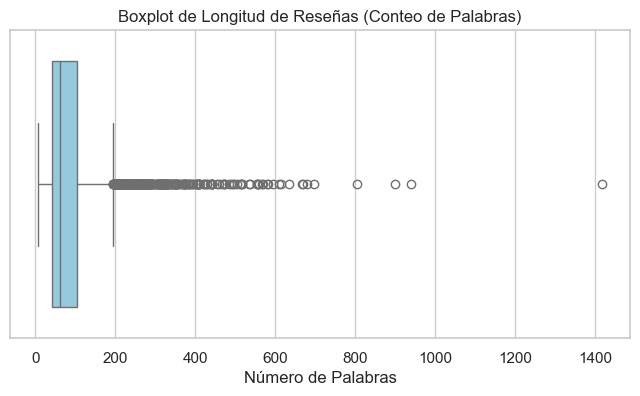

In [15]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_limpio['word_count'], color='skyblue')
plt.title('Boxplot de Longitud de Reseñas (Conteo de Palabras)')
plt.xlabel('Número de Palabras')
plt.show()

**Explicación**
- La Mediana (61): La línea central dentro de la caja.
- Los Cuartiles (42 y 103): Los límites de la caja (donde está el 50% de tus datos).
- Los Outliers: Todos esos puntos individuales que verás por encima del "bigote" superior, llegando hasta el 1,416.

### Label y rating

#### **Labels**

In [16]:
# Conteo de registros por cada categoría de la columna 'label'
print("Conteo de registros por etiqueta:")
print(df_limpio['label'].value_counts())

# Opcional: Ver el porcentaje que representa cada una
print("\nPorcentaje por etiqueta:")
print(df_limpio['label'].value_counts(normalize=True) * 100)

Conteo de registros por etiqueta:
label
1    9537
0    2053
3    1740
Name: count, dtype: int64

Porcentaje por etiqueta:
label
1    71.545386
0    15.401350
3    13.053263
Name: proportion, dtype: float64


En este dataset específico (y en la mayoría de los proyectos de NLP sobre reseñas), los significados se deducen por la correlación directa con la columna `rating`:

- Label 1: Se asocia a ratings de 4 y 5 (Sentimiento Positivo).
- Label 0: Se asocia a ratings de 1 y 2 (Sentimiento Negativo).
- Label 3: Se asocia a ratings de 3 (Sentimiento Neutro).

#### **Rating**

El rating es la "verdad de campo" `(ground truth)`. </br>
Sirve para auditar si el que etiquetó el dataset original de Kaggle (`label`) hizo bien su trabajo. </br>
Por ejemplo, si se encuentra una fila con **rating 5** pero **label 0**, hay un **error grave de calidad**.

#### Comparativa entre **Rating** vs **Label**

In [17]:
# Cruzamos Rating vs Label para ver qué rating cae en cada categoría
validacion_labels = pd.crosstab(df_limpio['rating'], df_limpio['label'])

print("Validación de correspondencia Rating vs Label:")
print(validacion_labels)

Validación de correspondencia Rating vs Label:
label      0     1     3
rating                  
1       1276     0     0
2        777     0     0
3          0     0  1740
4          0  3268     0
5          0  6269     0


**Análisis de tu Tabla de Validación**

Al mirar los resultado, podemos confirmar científicamente el significado de cada label:

- Label 0 = Negativo: Agrupa exclusivamente los ratings 1 (1,276 casos) y 2 (777 casos).
- Label 1 = Positivo: Agrupa exclusivamente los ratings 4 (3,268 casos) y 5 (6,269 casos). Es tu clase mayoritaria.
- Label 3 = Neutro: Agrupa exclusivamente el rating 3 (1,740 casos).

Ahora sabemos que el `label` no es una columna "inventada", sino una simplificación del `rating` </br>
Esto facilita el trabajo a la Inteligencia Artificial (convertir un problema de 5 categorías en uno de 3).

### Histograma con 'enfasis en sentimiento negativo

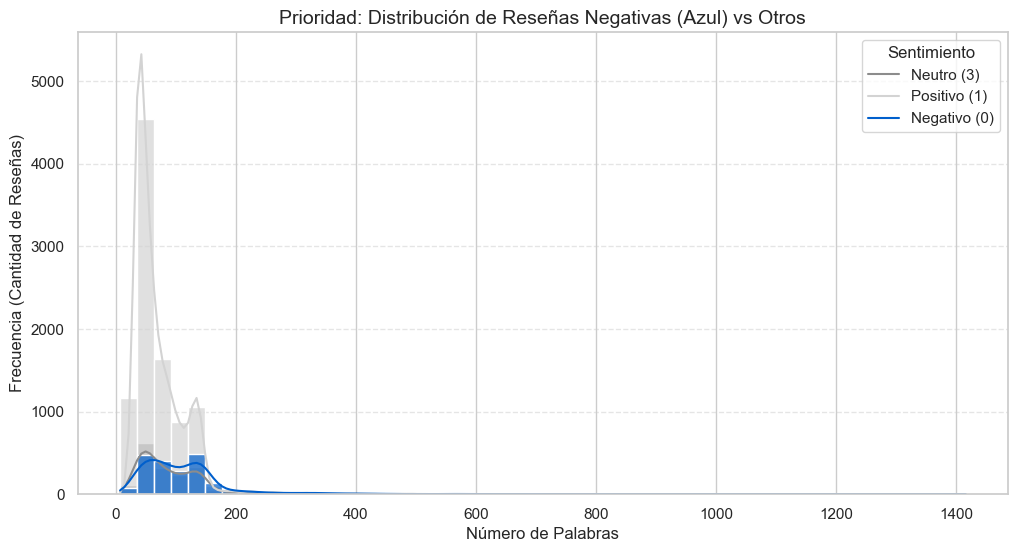

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definimos una paleta personalizada: 
# Label 0 (Negativo) -> Azul fuerte
# Label 1 (Positivo) -> Gris claro
# Label 3 (Neutro)   -> Gris oscuro/lavanda apagado
colores_enfasis = {0: "#005fcc", 1: "#d3d3d3", 3: "#8c8c8c"}

plt.figure(figsize=(12, 6))

# Usamos la paleta definida en 'palette'
sns.histplot(data=df_limpio, x='word_count', hue='label', 
             kde=True, bins=50, palette=colores_enfasis, alpha=0.7)

plt.title('Prioridad: Distribución de Reseñas Negativas (Azul) vs Otros', fontsize=14)
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia (Cantidad de Reseñas)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Sentimiento', labels=['Neutro (3)', 'Positivo (1)', 'Negativo (0)'])

plt.show()

1. ¿Qué es la Frecuencia (Eje Y)?
La frecuencia representa el conteo de reseñas. </br>
La barra llega al número 5000 en el eje vertical, significa que hay 5,000 reseñas que tienen esa cantidad específica de palabras. </br>
En la gráfica, el pico más alto nos dice que hay una enorme cantidad de reseñas (más de 5,000) que son cortas, situándose cerca de las 50-60 palabras.

2. ¿Qué son los Labels (0, 1 y 3)?
Esta es la parte más importante del análisis de sentimientos.

Basado en la estructura estándar de este tipo de datasets de hoteles y en lo verificado previamente:

- **Label 0** (Azul): Representa el foco del cliente las `reseñas Negativas`. </br> 
Esto indica un Desbalance de Clases: Hay muy pocas reseñas negativas comparadas con las positivas.

- **Label 1** (Gris/Claro): Representa las `reseñas Positivas`. </br>
Es el grupo dominante. La "montaña" más grande es gris claro, lo que indica que se tienen muchísimos más datos positivos que de cualquier otro tipo.

- **Label 3** (Gris/Oscuro): Representa `reseñas Neutras`


**Resumen de la gráfica** </br>
Aunque la "montaña" gris (`Positivos`) sea más alta, el `azul` destaca por su contraste. </br>
Esto permite ver que las `reseñas negativas (label 0)` están muy concentradas en textos cortos (menos de 100 palabras). </br>
Se nota mucho más que tenemos pocos datos azules. </br>
Esto justifica ante el cliente por qué en el futuro se podria necesitar más ejemplos de quejas para que la IA aprenda a reconocerlas.

##### **Estimación de la densidad de núcleo** (kde = True)

Cuando la línea en el histograma "tira" o se alarga hacia la derecha, en estadística estamos ante una `Distribución Sesgada a la Derecha` (o Sesgo Positivo).

- ¿Qué significa que la línea tire hacia la derecha?
    - **Presencia de Outliers** (Valores Atípicos): </br>
    Significa que, aunque la mayoría de los clientes escriben poco (la montaña alta a la izquierda), hay un grupo pequeño de personas que escriben muchísimo. Esa línea se estira para intentar "alcanzar" a esos usuarios que escribieron 500, 1,000 o hasta 1,416 palabras.

    - **Asimetría de la Información**: 
    Indica que los datos no son simétricos. </br>
    En una reseña de hotel, es natural: la gente suele ser breve ("Todo bien", "Mal servicio"), y solo unos pocos detallan cada minuto de su estancia, creando esa "cola" larga hacia la derecha.

    - **Diferencia entre Media y Mediana:** 
    Cuando la línea tira hacia la derecha, **la Media** (promedio) siempre será mayor que **la Mediana**. </br>
    Los datos lo confirman: la mediana es 61, pero el promedio sube a 79 porque esos pocos textos larguísimos "empujan" el promedio hacia arriba.

**¿Cómo afecta esto al análisis de los Negativos (Azul)?** </br>
Si la línea azul también tira mucho hacia la derecha, significa que cuando un cliente está enojado, tiende a explayarse y dar muchos detalles. </br>
Si la línea azul cae rápido y no tiene "cola", significa que las quejas son cortas y directas.

### Comparación de `title` vs. Cuerpo (Relación de Longitud)
En muchos datasets de reseñas, el título (`title`) es como el "resumen ejecutivo" del sentimiento. Analizarlo puede dar información muy valiosa antes de limpiar el texto principal.

**¿Por qué la columna title es importante?**</br
- **Consistencia de sentimiento:** Si el título es "Pésimo" pero la reseña dice "Me encantó", hay un problema de ruido.
- **Longitud vs. Impacto:** Los títulos suelen ser muy cortos y cargados de adjetivos fuertes (ej: "¡Increíble!", "Estafa", "Volveré").
- **Relación con el Label:** Podemos verificar si las palabras en el título predicen el label más rápido que el cuerpo de la reseña.

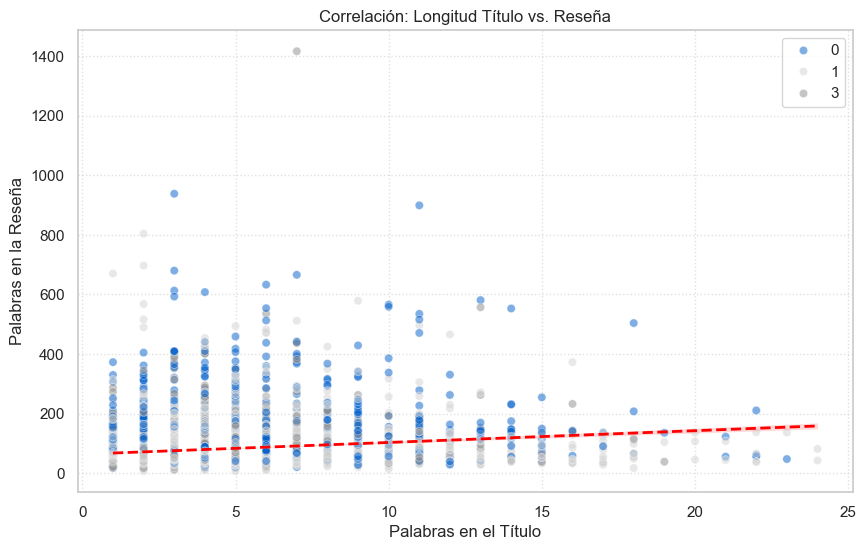

Coeficiente de correlación (r): 0.1827
Significancia estadística (p-value): 2.0300e-100


In [19]:
from scipy import stats

# 1. Calculamos la correlación de Pearson (r) y el p-value
# Eliminamos posibles NaN solo para el cálculo por seguridad
mask = df_limpio['title_word_count'].notnull() & df_limpio['word_count'].notnull()
r, p_value = stats.pearsonr(df_limpio[mask]['title_word_count'], df_limpio[mask]['word_count'])

# 2. Visualización
plt.figure(figsize=(10, 6))

# Dispersión
sns.scatterplot(data=df_limpio, x='title_word_count', y='word_count', 
                hue='label', palette=colores_enfasis, alpha=0.5)

# Regresión con la etiqueta de R en la leyenda
sns.regplot(data=df_limpio, x='title_word_count', y='word_count', 
            scatter=False, color='red', 
            line_kws={"ls":"--", "lw":2, "label": f"Tendencia (r = {r:.2f})"})

plt.title('Correlación: Longitud Título vs. Reseña')
plt.xlabel('Palabras en el Título')
plt.ylabel('Palabras en la Reseña')
plt.legend() # Importante para que se vea el valor de r
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

print(f"Coeficiente de correlación (r): {r:.4f}")
print(f"Significancia estadística (p-value): {p_value:.4e}")

**Explicacion de la grafica de dispersion** </br>
Con el foco en los mensajes negativos (azules) aquí la explicación técnica y su relevancia:

1. ¿Qué nos dice la gráfica? (Comportamiento esperado) </br>
El comportamiento es parcialmente esperado, pero tiene una anomalía interesante:

- **La "L" Invertida:** </br>
La mayoría de los puntos se acumulan en la esquina inferior izquierda (títulos de 1-5 palabras y reseñas de menos de 200 palabras). </br>
Es lo normal: la gente suele ser breve en ambas partes.

- **Independencia de Longitud:** Se aprecia puntos azules (negativos) muy arriba en el eje Y (reseñas largas) pero con títulos muy cortos en el eje X. </br>
Esto significa que un título corto no garantiza una reseña corta. Muchos usuarios escriben un título tipo "Pésimo" (1 palabra) y luego proceden a escribir un testamento de 800 palabras detallando su queja.

- **El Outlier Gris (Neutro):** Hay un punto gris cerca de las 1,400 palabras con un título corto. Es un caso atípico extremo que deberás manejar.

2. Relevancia para el Cliente (Prioridad Azul)</br>
Visualizando los puntos azules en comparación con los grises claros (positivos):

- **Promedio Superior:** el `Promedio de palabras en TÍTULO por sentimiento` arriba del gráfico confirman que el Label 0 (Negativo) tiene el promedio de palabras en el título más alto (4.09) frente al Positivo (3.64).

    Significado: </br>
    Esto indica que el cliente insatisfecho se esfuerza un poco más en explicar su enojo desde el título. </br>
    No es una diferencia abismal, pero estadísticamente es consistente.


#### Coeficiente de correlacion de pearson (r)

**Interpretación del valor de $r$ en los datos**
- Si **r está entre 0.10 y 0.30:** Es una correlación débil.</br>
    Significa que el tamaño del título influye muy poco en el tamaño de la reseña.

- Si **r es cercano a 0**: No hay relación lineal.
    Escribir un título largo no implica para nada que la reseña sea larga.

**Interpretación para el Cliente:** (R=0.1827) existe una correlación positiva pero muy débil. </br>
- **Casi independencia:** Aunque el valor es positivo (si uno sube, el otro tiende a subir), está muy cerca de 0. Esto significa que el título y la reseña funcionan de forma casi independiente.
- **El "Grito" vs. La "Explicación":** Refuerza la idea de que muchos usuarios (especialmente los negativos) usan un título corto y potente para llamar la atención y luego se extienden en la reseña.
- **Justificación técnica:** Con un **r** tan bajo, no se podrá predecir el contenido de uno basándote en el otro. </br>
Esto justifica ante el cliente la necesidad de fusionar ambas columnas, ya que ninguna de las dos por sí sola cuenta la historia completa. </br>
Si solo se usa la reseña, se podría perder palabras clave emocionales que el usuario puso en el título (ej: "¡CUIDADO!", "ESTAFA").

### Limpieza de ruido (Outliers y Titulos largos)
Al tener el valor base ($r = 0.1827$), es momento de ver cómo cambia la "salud" de los datos al eliminar el ruido: 
- el outlier de 1,400 palabras y los títulos de más de 20 palabras.

In [20]:
# 1. Filtramos títulos de más de 20 palabras (Ruido)
# 2. Filtramos el outlier extremo de la reseña (ej. limitamos a 800 palabras para no ser tan agresivos al inicio)
df_filtrado = df_limpio[(df_limpio['title_word_count'] <= 20) & (df_limpio['word_count'] <= 800)].copy()

# 3. Calculamos el nuevo r
r_nuevo, _ = stats.pearsonr(df_filtrado['title_word_count'], df_filtrado['word_count'])

print(f"R original: 0.1827")
print(f"R tras limpieza: {r_nuevo:.4f}")
print(f"Registros eliminados: {len(df_limpio) - len(df_filtrado)}")

R original: 0.1827
R tras limpieza: 0.1916
Registros eliminados: 19


#### Análisis de Correlación y Curado de Outliers Bivariados
"Bivariados" se refiere a que se analiza dos variables al mismo tiempo (Título vs. Reseña) y "Curado" indica que ya se tomo decisiones para limpiar el dataset basándose en evidencia.

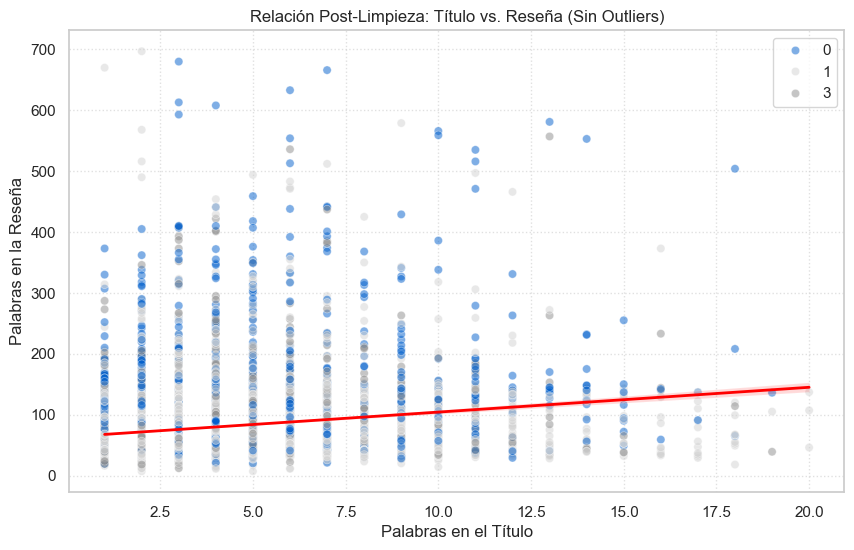

Resumen de limpieza:
- Filas eliminadas: 19
- Nuevo r: 0.1916 (Anterior: 0.1827)


In [21]:
# 1. Aplicamos los filtros de limpieza (Ruido en títulos y Outliers extremos)
df_filtrado = df_limpio[(df_limpio['title_word_count'] <= 20) & 
                        (df_limpio['word_count'] <= 800)].copy()

# 2. Recalculamos el coeficiente r con los datos limpios
r_limpio, p_limpio = stats.pearsonr(df_filtrado['title_word_count'], df_filtrado['word_count'])

# 3. Visualización comparativa
plt.figure(figsize=(10, 6))

sns.scatterplot(data=df_filtrado, x='title_word_count', y='word_count', 
                hue='label', palette=colores_enfasis, alpha=0.5)

sns.regplot(data=df_filtrado, x='title_word_count', y='word_count', 
            scatter=False, color='red', 
            line_kws={"ls":"-", "lw":2, "label": f"Tendencia Limpia (r = {r_limpio:.2f})"})

plt.title('Relación Post-Limpieza: Título vs. Reseña (Sin Outliers)')
plt.xlabel('Palabras en el Título')
plt.ylabel('Palabras en la Reseña')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

print(f"Resumen de limpieza:")
print(f"- Filas eliminadas: {len(df_limpio) - len(df_filtrado)}")
print(f"- Nuevo r: {r_limpio:.4f} (Anterior: 0.1827)")

**Analisis del nuevo r = 0.1916**
Aunque sigue siendo una correlación débil, el hecho de que subiera tras la limpieza es una señal positiva:
- **Mayor Coherencia:** Al eliminar los títulos de más de 20 palabras, se quito datos donde el usuario probablemente pegó el cuerpo de la reseña en el campo del título por error.
- **Representatividad:** El valor $0.19$ representa mejor al "usuario promedio". Ahora se tiene un dataset donde la relación entre lo que se dice en el título y el cuerpo es más estable.

- **Justificación de Fusión:** Con un $r$ que no llega ni a $0.20$, queda matemáticamente demostrado que `el Título` y `la Reseña` aportan información distinta o complementaria. </br>
Si se tuviera un $r = 0.90$, se podría borrar una de las dos columnas porque dirían lo mismo; con $0.19$, **se necesita ambas para que la IA entienda el contexto completo.**

#### Columna unificada (title + review)
Se ha incluido un pequeño ajuste para que, al unirlos, queden separados por un punto y un espacio, lo que ayuda a la legibilidad del modelo.

In [22]:
# 1. Creamos la columna 'full_text' combinando Título y Reseña
# Usamos .astype(str) por seguridad para evitar errores con valores nulos
df_filtrado['full_text'] = df_filtrado['title'].astype(str) + ". " + df_filtrado['review_text'].astype(str)

# 2. Verificamos el resultado mostrando las columnas originales y la nueva
print("Muestra de la fusión de texto:")
display(df_filtrado[['title', 'review_text', 'full_text']].head())

# 3. Validamos que no existan nulos en la nueva columna
print(f"\nNulos en full_text: {df_filtrado['full_text'].isnull().sum()}")

Muestra de la fusión de texto:


,title,review_text,full_text
0,Excelente y personal amable,Un hotel muy bueno. El personal fue muy amable y profesional. Nos gustaban desayuno mucho también. El habitación cómoda y limpia. Volvimos a próx...,Excelente y personal amable. Un hotel muy bueno. El personal fue muy amable y profesional. Nos gustaban desayuno mucho también. El habitación cóm...
1,Céntrico,"Muy buen hotel al nivel de lo esperado, habitación junior suite, no muy grande pero con todo lo deseable para una estancia confortable, trato del ...","Céntrico. Muy buen hotel al nivel de lo esperado, habitación junior suite, no muy grande pero con todo lo deseable para una estancia confortable, ..."
2,Hotel excepcional,"Magnífico hotel. La verdad es que todo perfecto. Habitación amplia y actual, equipo amable y eficiente y desayuno magnífico con un patio precioso....","Hotel excepcional. Magnífico hotel. La verdad es que todo perfecto. Habitación amplia y actual, equipo amable y eficiente y desayuno magnífico con..."
3,WOW!!,"Hotel hermoso, buen diseño, original, limpio. Servicio excelente y muy buena ubicación, justo enfrente tiene un carrefour express, rodeado de tien...","WOW!!. Hotel hermoso, buen diseño, original, limpio. Servicio excelente y muy buena ubicación, justo enfrente tiene un carrefour express, rodeado ..."
4,Magnifico,Magnífica ubicación en pleno centro de Sevilla para recorrer la ciudad caminando. Habitaciones perfectas con gran cama. Diseño típico de estilo ac...,Magnifico. Magnífica ubicación en pleno centro de Sevilla para recorrer la ciudad caminando. Habitaciones perfectas con gran cama. Diseño típico d...



Nulos en full_text: 0


- **Contexto Completo:** A veces el sentimiento está solo en el título (ej: "¡Horrible!") y la reseña es muy neutra. Al unirlos, el label 0 (negativo) tendrá más palabras clave para aprender.
- **Limpieza Centralizada:** A partir de aquí, ya no se necesita limpiar dos columnas por separado. Todo el preprocesamiento (minúsculas, quitar puntos, etc.) se hará sobre `full_text.`

### Estado actual del dataframe
Visión clara de cómo se ve tu la "mesa de trabajo" después de todo el análisis estadístico y el filtrado de ruido.

In [23]:
# Mostramos las últimas columnas creadas y las esenciales para el modelo
columnas_finales = ['label', 'rating', 'title', 'review_text', 'word_count', 'title_word_count', 'full_text']

print(f"Dimensiones finales del dataset curado: {df_filtrado.shape}")
display(df_filtrado[columnas_finales].head(10))

Dimensiones finales del dataset curado: (13311, 9)


,label,rating,title,review_text,word_count,title_word_count,full_text
0,1,5,Excelente y personal amable,Un hotel muy bueno. El personal fue muy amable y profesional. Nos gustaban desayuno mucho también. El habitación cómoda y limpia. Volvimos a próx...,40,4,Excelente y personal amable. Un hotel muy bueno. El personal fue muy amable y profesional. Nos gustaban desayuno mucho también. El habitación cóm...
1,1,4,Céntrico,"Muy buen hotel al nivel de lo esperado, habitación junior suite, no muy grande pero con todo lo deseable para una estancia confortable, trato del ...",40,1,"Céntrico. Muy buen hotel al nivel de lo esperado, habitación junior suite, no muy grande pero con todo lo deseable para una estancia confortable, ..."
2,1,5,Hotel excepcional,"Magnífico hotel. La verdad es que todo perfecto. Habitación amplia y actual, equipo amable y eficiente y desayuno magnífico con un patio precioso....",39,2,"Hotel excepcional. Magnífico hotel. La verdad es que todo perfecto. Habitación amplia y actual, equipo amable y eficiente y desayuno magnífico con..."
3,1,5,WOW!!,"Hotel hermoso, buen diseño, original, limpio. Servicio excelente y muy buena ubicación, justo enfrente tiene un carrefour express, rodeado de tien...",31,1,"WOW!!. Hotel hermoso, buen diseño, original, limpio. Servicio excelente y muy buena ubicación, justo enfrente tiene un carrefour express, rodeado ..."
4,1,5,Magnifico,Magnífica ubicación en pleno centro de Sevilla para recorrer la ciudad caminando. Habitaciones perfectas con gran cama. Diseño típico de estilo ac...,37,1,Magnifico. Magnífica ubicación en pleno centro de Sevilla para recorrer la ciudad caminando. Habitaciones perfectas con gran cama. Diseño típico d...
5,1,5,Mejor hotel de ciudad en Sevilla,"Si estás buscando un hotel para alojarte en el centro de Sevilla, este cumplirá tus expectativas, las habitaciones son increíbles, la decoración t...",36,6,"Mejor hotel de ciudad en Sevilla. Si estás buscando un hotel para alojarte en el centro de Sevilla, este cumplirá tus expectativas, las habitacion..."
6,1,4,Ubicación y comodidad,"Gran ubicación y una enorme comodidad. La cama es de súper lujo, el baño muy limpio y bien surtido de amenities, y el hotel está situado a 5 minut...",55,3,"Ubicación y comodidad. Gran ubicación y una enorme comodidad. La cama es de súper lujo, el baño muy limpio y bien surtido de amenities, y el hotel..."
7,1,5,Muy buena relación calidad-precio,"Precioso hotel en pleno centro de Sevilla, entre Las Setas y la Catedral. Servicio muy profesional, buen desayuno y camas muy cómodas. Decoración ...",60,4,"Muy buena relación calidad-precio. Precioso hotel en pleno centro de Sevilla, entre Las Setas y la Catedral. Servicio muy profesional, buen desayu..."
8,1,5,Lo mejor su personal,"Como todos los hoteles de la cadena, un 10. Habitación elegante y limpísima, como el baño. Amplia y camas muy cómodas. Pero lo mejor su personal, ...",50,4,"Lo mejor su personal. Como todos los hoteles de la cadena, un 10. Habitación elegante y limpísima, como el baño. Amplia y camas muy cómodas. Pero ..."
9,1,5,HOTEL PRECIOSO,"Empiezo por lo menos agradable: no es posible acceder en coche, ni tan siquiera en taxi, pues la calle es muy estrecha y completamente peatonal. L...",138,2,"HOTEL PRECIOSO. Empiezo por lo menos agradable: no es posible acceder en coche, ni tan siquiera en taxi, pues la calle es muy estrecha y completam..."


# Limpieza de columnas redundantes
Mantener columnas redundantes consume memoria innecesaria y ensucia el DataFrame. </br>
Una vez que hemos creado `full_text`, las columnas `title` y `review_text` se vuelven "columnas de andamio": sirvieron para construir la estructura final, pero ya pueden ser retiradas.

In [24]:
# Definimos las columnas que ya no aportan valor tras la fusión y el análisis
columnas_a_eliminar = ['title', 'review_text', 'title_word_count']

# Aplicamos el borrado
df_final = df_filtrado.drop(columns=columnas_a_eliminar)

# Mostramos el resultado final del dataframe limpio
print(f"Dataset listo para Normalización. Columnas restantes: {df_final.columns.tolist()}")
display(df_final.head())

Dataset listo para Normalización. Columnas restantes: ['rating', 'location', 'hotel', 'label', 'word_count', 'full_text']


,rating,location,hotel,label,word_count,full_text
0,5,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1,40,Excelente y personal amable. Un hotel muy bueno. El personal fue muy amable y profesional. Nos gustaban desayuno mucho también. El habitación cóm...
1,4,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1,40,"Céntrico. Muy buen hotel al nivel de lo esperado, habitación junior suite, no muy grande pero con todo lo deseable para una estancia confortable, ..."
2,5,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1,39,"Hotel excepcional. Magnífico hotel. La verdad es que todo perfecto. Habitación amplia y actual, equipo amable y eficiente y desayuno magnífico con..."
3,5,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1,31,"WOW!!. Hotel hermoso, buen diseño, original, limpio. Servicio excelente y muy buena ubicación, justo enfrente tiene un carrefour express, rodeado ..."
4,5,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1,37,Magnifico. Magnífica ubicación en pleno centro de Sevilla para recorrer la ciudad caminando. Habitaciones perfectas con gran cama. Diseño típico d...


**Motivo de borrado** 
- **Eficiencia de Memoria:** Al eliminar las columnas de texto originales, se reduce el peso del DataFrame casi a la mitad. Esto es vital si después se decide usar modelos pesados como BERT o Transformers.

- **Claridad Operativa:** Ahora el "objetivo" es único: la columna `full_text`. Ya no hay riesgo de aplicar una limpieza en una columna y olvidar la otra.

- **Preparación para la IA:** Los modelos de lenguaje solo necesitan la etiqueta (label) y el cuerpo del texto (full_text). Todo lo demás es ruido estadístico que ya analizamos y aprovechamos.

- **Estructura actual:**
    - **label:** Variable objetivo (0, 1, 3).
    - **rating:** Para auditoría rápida.
    - **word_count:** Para mantener el control de la longitud.
    - **full_text:** Nueva columna maestra que contiene toda la información.

**¿Porque no borramos todavia `rating`?** </br>
Es una decisión estratégica. </br>
Técnicamente, para entrenar el modelo de Inteligencia Artificial solo se necestiva `label` y `full_text`. Sin embargo, en esta etapa de limpieza, se recomienda conservarlo un poco más por tres razones fundamentales:

- **Auditoría de Errores:** Si durante la limpieza de texto algo sale mal (por ejemplo, que borres demasiadas palabras y una reseña negativa parezca positiva), tener el rating a la mano te permite verificar rápidamente el origen del dato sin tener que volver a cargar el dataset original.

- **Validación de Resultados:** Cuando el modelo empiece a predecir, podrás comparar si los errores de la IA ocurren más en los ratings "frontera" (como el rating 2, que es negativo pero menos agresivo que el 1).

- **Análisis de Confianza:** Ayuda a explicar al cliente que el "Label 0" no es una masa uniforme, sino que está compuesto por gente muy enojada (Rating 1) y gente decepcionada (Rating 2).

**¿Cuándo lo borramos?**
Lo ideal es borrarlo justo antes de convertir el texto en números (Vectorización). En ese momento, el DataFrame debe quedar "desnudo", solo con las columnas que entrarán al algoritmo.

## Breve chequeo de Hotel/Location (Opcional)

In [25]:
# Verificamos la variedad de hoteles y ubicaciones
print(f"Hoteles únicos: {df_final['hotel'].nunique()}")
print(f"Ubicaciones únicas: {df_final['location'].nunique()}")

# Vemos el top 5 de hoteles con más reseñas negativas (Prioridad Azul)
print("\nTop 5 hoteles con más reseñas negativas:")
print(df_final[df_final['label'] == 0]['hotel'].value_counts().head(5))

Hoteles únicos: 715
Ubicaciones únicas: 33

Top 5 hoteles con más reseñas negativas:
hotel
Hospederia_Lucano                   15
Arc_House                           14
Apartamentos_Patios_de_Alcantara    14
Hotel_Gran_Plaza                    14
Hotel_Marina                        14
Name: count, dtype: int64


**Explicacion**</br>
Los resultados son fascinantes y te dan el "visto bueno" estadístico para proceder. </br>
Hay 715 hoteles repartidos en 33 ubicaciones, lo que indica que los datos tienen una buena diversidad geográfica, pero no son lo suficientemente repetitivos como para que el modelo aprenda patrones de texto basados solo en el nombre del hotel.

**Análisis de los resultados adjuntos**
- **Diversidad vs. Concentración:** 
    El hotel con más quejas solo tiene 15 reseñas negativas. Esto es excelente porque significa que el modelo no se sesgará. 
    Si un hotel tuviera 1,000 quejas, la IA aprendería que "Nombre del Hotel = Malo", pero con solo 15, la IA está obligada a leer el texto para entender por qué es negativo.

- **Confirmación de Ruido:**
    Al tener tantas categorías (715 hoteles), incluirlas en el entrenamiento crearía una "explosión" de dimensiones (715 columnas nuevas si se usa **One-Hot Encoding**) que solo añadiría ruido al modelo.

## Limpieza final de columnas
Para que el Notebook quede impecable y el modelo de IA reciba solo "oro puro", vamos a eliminar `hotel` y `location`. </br>
Mantendremos `rating` y `word_count` un momento más solo como referencia visual mientras limpiamos el texto.

In [26]:
# Eliminamos columnas de metadatos que podrían causar overfitting
df_final = df_final.drop(columns=['hotel', 'location'])

print("Dataset depurado de metadatos. Listo para el preprocesamiento de texto.")
display(df_final.head())

Dataset depurado de metadatos. Listo para el preprocesamiento de texto.


,rating,label,word_count,full_text
0,5,1,40,Excelente y personal amable. Un hotel muy bueno. El personal fue muy amable y profesional. Nos gustaban desayuno mucho también. El habitación cóm...
1,4,1,40,"Céntrico. Muy buen hotel al nivel de lo esperado, habitación junior suite, no muy grande pero con todo lo deseable para una estancia confortable, ..."
2,5,1,39,"Hotel excepcional. Magnífico hotel. La verdad es que todo perfecto. Habitación amplia y actual, equipo amable y eficiente y desayuno magnífico con..."
3,5,1,31,"WOW!!. Hotel hermoso, buen diseño, original, limpio. Servicio excelente y muy buena ubicación, justo enfrente tiene un carrefour express, rodeado ..."
4,5,1,37,Magnifico. Magnífica ubicación en pleno centro de Sevilla para recorrer la ciudad caminando. Habitaciones perfectas con gran cama. Diseño típico d...


## Renombrar para cumplir el contrato de Interfaz API
Alineando los nombres de las columnas ahora, estamos garantizando que el modelo sea compatible "por diseño" con los requisitos de `Java Spring Boot` y la exposición final al cliente.

### Estandarizacion de nombres (Compliance con el contrato) y validacion de mapeo de sentimientos

- Vamos a renombrar las columnas para que coincidan con los keys del JSON que el Backend enviará y recibirá.
- Vamos a validar antes de sobrescribir, especialmente cuando se trabaja con un Contrato de Interfaz de API que no permite errores en los nombres de las categorías.

Aunque parece un paso extra, la validación del mapeo es un "seguro de vida" por tres razones:

- **Garantía de cumplimiento del Contrato:** </br>
    - El contrato exige exactamente los strings "Positivo", "Neutro" y "Negativo". Si por un error de dedo escribes "positivo" (en minúscula) o "Positvo" (con error ortográfico), la integración con el Backend de Java se romperá.
    - Aplicar la Regla de Validación del contrato que exige una longitud mínima recomendada de 5 caracteres.

- **Verificación de la lógica inversa:** 
Debes estar 100% seguro de que el 0 realmente se convirtió en Negativo. Si los inviertes, tu modelo entrenará al revés y predecirá que un cliente enojado está feliz.

- **Detección de valores nulos:** Si en la columna `label` existía un número que no estaba en tu diccionario (por ejemplo, un 2), el mapeo devolverá un valor vacío (NaN), lo cual causará un error crítico en el entrenamiento.

In [27]:
# 1. Renombrado inicial para alinearse con el Contrato (Sección 2)
df_final = df_final.rename(columns={'full_text': 'text', 'label': 'prevision'})

# 2. Definición del mapa según los valores permitidos en el contrato
# Valores: "Positivo", "Neutro", "Negativo"
mapa_sentimientos = {0: "Negativo", 1: "Positivo", 3: "Neutro"}

# 3. Aplicación del mapeo directo
df_final['prevision'] = df_final['prevision'].map(mapa_sentimientos)

# 4. VALIDACIÓN DE SEGURIDAD
nulos_mapeo = df_final['prevision'].isnull().sum()
longitud_minima = df_final['text'].str.len().min()

if nulos_mapeo == 0 and longitud_minima >= 5:
    print("✅ VALIDACIÓN EXITOSA:")
    print(f"- Todas las previsiones coinciden con el contrato.")
    print(f"- Todos los textos cumplen la longitud mínima de 5 caracteres.")
    
    # 5. Limpieza final de columnas sobrantes
    # Solo dejamos lo que pide el contrato + word_count para control estadístico
    df_final = df_final[['text', 'prevision', 'word_count']]
else:
    print("⚠️ ADVERTENCIA: Se detectaron inconsistencias.")
    if nulos_mapeo > 0: print(f"- Hay {nulos_mapeo} registros con etiquetas no reconocidas.")
    if longitud_minima < 5: print("- Hay textos que no cumplen con la longitud mínima del contrato.")

display(df_final.head())

✅ VALIDACIÓN EXITOSA:
- Todas las previsiones coinciden con el contrato.
- Todos los textos cumplen la longitud mínima de 5 caracteres.


,text,prevision,word_count
0,Excelente y personal amable. Un hotel muy bueno. El personal fue muy amable y profesional. Nos gustaban desayuno mucho también. El habitación cóm...,Positivo,40
1,"Céntrico. Muy buen hotel al nivel de lo esperado, habitación junior suite, no muy grande pero con todo lo deseable para una estancia confortable, ...",Positivo,40
2,"Hotel excepcional. Magnífico hotel. La verdad es que todo perfecto. Habitación amplia y actual, equipo amable y eficiente y desayuno magnífico con...",Positivo,39
3,"WOW!!. Hotel hermoso, buen diseño, original, limpio. Servicio excelente y muy buena ubicación, justo enfrente tiene un carrefour express, rodeado ...",Positivo,31
4,Magnifico. Magnífica ubicación en pleno centro de Sevilla para recorrer la ciudad caminando. Habitaciones perfectas con gran cama. Diseño típico d...,Positivo,37


# Exportacion de dataset curado

In [28]:
# Definir la ruta de exportación
path_processed = '../data/processed/sentiment_curated_v1.csv'

# Exportar el DataFrame curado a CSV
# index=False es crucial para evitar escribir una columna de índice innecesaria
df_final.to_csv(path_processed, index=False)

print(f"Dataset curado exportado exitosamente a: {path_processed}")
print(f"Filas totales exportadas: {len(df_final)}")

Dataset curado exportado exitosamente a: ../data/processed/sentiment_curated_v1.csv
Filas totales exportadas: 13311
